<a href="https://colab.research.google.com/github/marissa-graham/deep_learning/blob/master/Lab_4_(Cancer_Detection).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installs and imports

In [0]:
!pip install --no-cache-dir -I pillow
!pip3 install torch torchvision tqdm

    100% |████████████████████████████████| 2.0MB 38.2MB/s 


In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import PIL.Image
def register_extension(id, extension):
    PIL.Image.EXTENSION[extension.lower()] = id.upper()
PIL.Image.register_extension = register_extension

def register_extensions(id, extensions):
    for extension in extensions:
        register_extension(id, extension)
PIL.Image.register_extensions = register_extensions

import seaborn
import numpy as np
from scipy import linalg as la
from matplotlib import pyplot as plt
from torchvision import transforms, utils, datasets
from tqdm import tqdm

assert torch.cuda.is_available()

# CancerDataset class

In [0]:
import torchvision
import os
import gzip
import tarfile
import gc
from IPython.core.ultratb import AutoFormattedTB
__ITB__ = AutoFormattedTB(mode = 'Verbose',color_scheme='LightBg', tb_offset = 1)
 
class CancerDataset(Dataset):
    
    def __init__(self, root, download=True, size=512, train=True):
        if download and not os.path.exists(os.path.join(root, 'cancer_data')):
            
            datasets.utils.download_url(
                'http://liftothers.org/cancer_data.tar.gz', 
                root, 'cancer_data.tar.gz', None)
            
            self.extract_gzip(os.path.join(root, 'cancer_data.tar.gz'))
            self.extract_tar(os.path.join(root, 'cancer_data.tar'))

        postfix = 'train' if train else 'test'
        root = os.path.join(root, 'cancer_data', 'cancer_data')
        
        self.dataset_folder = torchvision.datasets.ImageFolder(
            os.path.join(root, 'inputs_' + postfix),
            transform = transforms.Compose([transforms.Resize(size), 
                                            transforms.ToTensor()]))
        print("len(dataset_folder):", len(self.dataset_folder))
        self.label_folder = torchvision.datasets.ImageFolder(
            os.path.join(root, 'outputs_' + postfix), 
            transform = transforms.Compose([transforms.Resize(size),
                                            transforms.ToTensor()]))

    @staticmethod
    def extract_gzip(gzip_path, remove_finished=False):
        
        print('Extracting {}'.format(gzip_path))
        
        newpath = gzip_path.replace('.gz', '')
        with open(newpath, 'wb') as out_f, gzip.GzipFile(gzip_path) as zip_f:
            out_f.write(zip_f.read())
            
        if remove_finished:
            os.unlink(gzip_path)

    @staticmethod
    def extract_tar(tar_path):
        
        print('Untarring {}'.format(tar_path))
        z = tarfile.TarFile(tar_path)
        z.extractall(tar_path.replace('.tar', ''))


    def __getitem__(self, index):
        
        img = self.dataset_folder[index]
        label = self.label_folder[index]
        return img[0], label[0][0]

    def __len__(self):
        return len(self.dataset_folder)

In [0]:
CancerDataset('C:/Users/Marissa', size=512)

Extracting C:/Users/Marissa/cancer_data.tar.gz
Untarring C:/Users/Marissa/cancer_data.tar
len(dataset_folder): 1342


# CancerDetection module

In [0]:
class CancerDetector(nn.Module):
  
    def __init__(self, dataset):
        
        super(CancerDetector, self).__init__()
        
        x, y = dataset[0]
        c, h, w = x.size()
        output = 2
        
        # Channel building and consolidation on each layer
        
        self.conv1a = nn.Conv2d(c, 64, 3, stride=1, padding=1)
        self.relu1a = nn.ReLU()
        self.conv1b = nn.Conv2d(64, 64, 3, stride=1, padding=1)
        self.relu1b = nn.ReLU()
        
        self.conv2a = nn.Conv2d(64, 128, 3, stride=1, padding=1)
        self.relu2a = nn.ReLU()
        self.conv2b = nn.Conv2d(128, 128, 3, stride=1, padding=1)
        self.relu2b = nn.ReLU()
        
        self.conv3a = nn.Conv2d(128, 256, 3, stride=1, padding=1)
        self.relu3a = nn.ReLU()
        self.conv3b = nn.Conv2d(256, 256, 3, stride=1, padding=1)
        self.relu3b = nn.ReLU()
        
        self.conv4a = nn.Conv2d(256, 512, 3, stride=1, padding=1)
        self.relu4a = nn.ReLU()
        self.conv4b = nn.Conv2d(512, 512, 3, stride=1, padding=1)
        self.relu4b = nn.ReLU()
        
        self.conv5a = nn.Conv2d(512, 1024, 3, stride=1, padding=1)
        self.relu5a = nn.ReLU()
        self.conv5b = nn.Conv2d(1024, 1024, 3, stride=1, padding=1)
        self.relu5b = nn.ReLU()
        
        self.conv4c = nn.Conv2d(1024, 512, 3, stride=1, padding=1)
        self.relu4c = nn.ReLU()
        self.conv4d = nn.Conv2d(512, 512, 3, stride=1, padding=1)
        self.relu4d = nn.ReLU()
        
        self.conv3c = nn.Conv2d(512, 256, 3, stride=1, padding=1)
        self.relu3c = nn.ReLU()
        self.conv3d = nn.Conv2d(256, 256, 3, stride=1, padding=1)
        self.relu3d = nn.ReLU()
        
        self.conv2c = nn.Conv2d(256, 128, 3, stride=1, padding=1)
        self.relu2c = nn.ReLU()
        self.conv2d = nn.Conv2d(128, 128, 3, stride=1, padding=1)
        self.relu2d = nn.ReLU()
        
        self.conv1c = nn.Conv2d(128, 64, 3, stride=1, padding=1)
        self.relu1c = nn.ReLU()
        self.conv1d = nn.Conv2d(64, 64, 3, stride=1, padding=1)
        self.relu1d = nn.ReLU()
        self.conv1e = nn.Conv2d(64, output, 3, stride=1, padding=1)
        self.relu1e = nn.ReLU()
        
        # Downsampling and up-convolutions
        self.down12 = nn.Conv2d(64, 64, 2, stride=2, padding=0)
        self.down23 = nn.Conv2d(128, 128, 2, stride=2, padding=0)
        self.down34 = nn.Conv2d(256, 256, 2, stride=2, padding=0)
        self.down45 = nn.Conv2d(512, 512, 2, stride=2, padding=0)
        
        self.up54 = nn.ConvTranspose2d(1024, 512, 2, stride=2, padding=0)
        self.up43 = nn.ConvTranspose2d(512, 256, 2, stride=2, padding=0)
        self.up32 = nn.ConvTranspose2d(256, 128, 2, stride=2, padding=0)
        self.up21 = nn.ConvTranspose2d(128, 64, 2, stride=2, padding=0)
        

    def forward(self, input):
        """
        Input is size 3 x 16a x 16a for some integer a. 
        
        Commented out the 'print out the size after each step of the U' that 
        we used for debugging.
        """
        
        # Layer 1 channel building (3 -> 64 -> 64)
        conv1a_out = self.conv1a(input)
        relu1a_out = self.relu1a(conv1a_out)
        conv1b_out = self.conv1b(relu1a_out)
        relu1b_out = self.relu1b(conv1b_out)
        #print("After layer 1 channel building:", relu1b_out.size())
        
        # Downsample to Layer 2 size (16a -> 8a)
        down12_out = self.down12(relu1b_out)
        #print("After downsampling to layer 2 size:", down12_out.size())
        
        # Layer 2 channel building (64 -> 128 -> 128)
        conv2a_out = self.conv2a(down12_out)
        relu2a_out = self.relu2a(conv2a_out)
        conv2b_out = self.conv2b(relu2a_out)
        relu2b_out = self.relu2b(conv2b_out)
        #print("After layer 2 channel building:", relu2b_out.size())
        
        # Downsample to Layer 3 size (8a -> 4a)
        down23_out = self.down23(relu2b_out)
        #print("After downsampling to layer 3 size:", down23_out.size())
        
        # Layer 3 channel building (128 -> 256 -> 256)
        conv3a_out = self.conv3a(down23_out)
        relu3a_out = self.relu3a(conv3a_out)
        conv3b_out = self.conv3b(relu3a_out)
        relu3b_out = self.relu3b(conv3b_out)
        #print("After layer 3 channel building:", relu3b_out.size())
        
        # Downsample to Layer 4 size (4a -> 2a)
        down34_out = self.down34(relu3b_out)
        #print("After downsampling to layer 4 size:", down34_out.size())
        
        # Layer 4 channel building (256 -> 512 -> 512)
        conv4a_out = self.conv4a(down34_out)
        relu4a_out = self.relu4a(conv4a_out)
        conv4b_out = self.conv4b(relu4a_out)
        relu4b_out = self.relu4b(conv4b_out)
        #print("After layer 4 channel building:", relu4b_out.size())
        
        # Downsample to Layer 5 size (2a -> a)
        down45_out = self.down45(relu4b_out)
        #print("After downsampling to layer 5 size:", down45_out.size())
        
        # Layer 5 channel building (512 -> 1024 -> 1024)
        conv5a_out = self.conv5a(down45_out)
        relu5a_out = self.relu5a(conv5a_out)
        conv5b_out = self.conv5b(relu5a_out)
        relu5b_out = self.relu5b(conv5b_out)
        #print("After layer 5 channel building:", relu5b_out.size())
        
        # Append Layer 4 output to Layer 5 up-convolution 
        up54_out = self.up54(relu5b_out)
        #print("Layer 5 up-convolution:", up54_out.size())
        layer4concat = torch.cat((relu4b_out, up54_out), 1) 
        #print("Concatenation in prep for layer 4:", layer4concat.size())
        
        # Layer 4 channel consolidation (1024 -> 512 -> 512)
        conv4c_out = self.conv4c(layer4concat)
        relu4c_out = self.relu4c(conv4c_out)
        conv4d_out = self.conv4d(relu4c_out)
        relu4d_out = self.relu4d(conv4d_out)
        #print("After layer 4 channel consolidation:", relu4d_out.size())
        
        # Append Layer 3 output to Layer 4 up-convolution
        up43_out = self.up43(relu4d_out)
        layer3concat = torch.cat((relu3b_out, up43_out), 1)
        #print("Concatenation in prep for layer 3:", layer3concat.size())
        
        # Layer 3 channel consolidation (512 -> 256 -> 256)
        conv3c_out = self.conv3c(layer3concat)
        relu3c_out = self.relu3c(conv3c_out)
        conv3d_out = self.conv3d(relu3c_out)
        relu3d_out = self.relu3d(conv3d_out)
        #print("After layer 3 channel consolidation:", relu3d_out.size())
        
        # Append Layer 2 output to Layer 3 up-convolution
        up32_out = self.up32(relu3d_out)
        layer2concat = torch.cat((relu2b_out, up32_out), 1)
        #print("Concatenation in prep for layer 2:", layer2concat.size())
        
        # Layer 2 channel consolidation (256 -> 128 -> 128)
        conv2c_out = self.conv2c(layer2concat)
        relu2c_out = self.relu2c(conv2c_out)
        conv2d_out = self.conv2d(relu2c_out)
        relu2d_out = self.relu2d(conv2d_out)
        #print("After layer 2 channel consolidation:", relu2d_out.size())
        
        # Append Layer 1 output to Layer 2 up-convolution
        up21_out = self.up21(relu2d_out)
        layer1concat = torch.cat((relu1b_out, up21_out), 1)
        #print("Concatenation in prep for layer 4:", layer4concat.size())
        
        # Layer 1 channel consolidation (128 -> 64 -> 64 -> 2)
        conv1c_out = self.conv1c(layer1concat)
        relu1c_out = self.relu1c(conv1c_out)
        conv1d_out = self.conv1d(relu1c_out)
        relu1d_out = self.relu1d(conv1d_out)
        conv1e_out = self.conv1e(relu1d_out)
        #print("After layer 1 channel consolidation:", conv1e_out.size())
        return self.relu1e(conv1e_out)
        

# Helper code for displaying results

In [0]:
def show_img(image, title, epoch, color=False):
    
    image = image.squeeze(0) # squeeze out the batch size
    
    if color:
        image = image.permute(1,2,0)
    else:
        image = image[-1]
    
    
    plt.imshow(image.detach())
    plt.grid(None)
    plt.yticks([])
    plt.xticks([])
    plt.title(title)
    plt.savefig('/gdrive/My Drive/Colab Notebooks/'+title+"_epoch"+str(epoch))
    plt.show()
    
def display_results(losses, train_accuracies, val_data, model, epoch):
    
    final_test_img = val_data[172][0].unsqueeze(0).cuda()
    our_classification = model(final_test_img)
    final_test_label = val_data[172][1].unsqueeze(0).unsqueeze(0).cuda()

    show_img(final_test_img, "Original test image 72", epoch, color=True)
    show_img(our_classification, "Our prediction", epoch)
    show_img(final_test_label, "Correct image labeling", epoch)
    
    #a, b = zip(*validations)
    #plt.plot(a, b, label='val')
    plt.plot(losses, label='train')
    plt.xlabel('Batch number')
    plt.ylabel('Loss')
    plt.title("Loss over time")
    plt.legend()
    plt.show()

# Run tests

Mounted at /gdrive


  0%|          | 0/671 [00:00<?, ?it/s]

0.666579968


Epoch 1: loss 0.4064, acc. 0.852: 100%|██████████| 671/671 [20:40<00:00,  1.84s/it]
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type CancerDetector. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


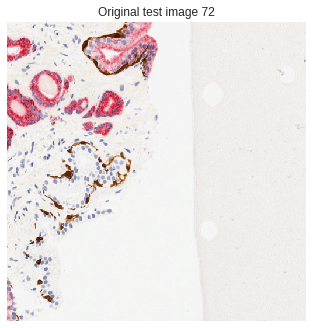

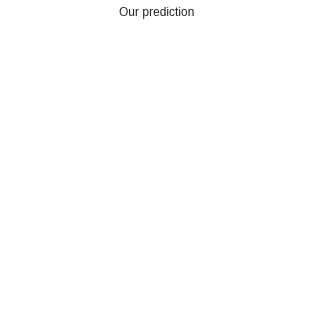

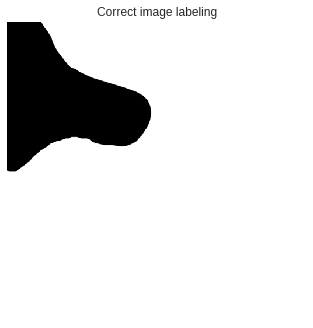

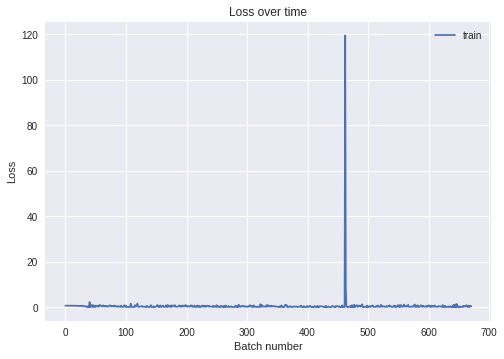

Epoch 2: loss 0.1554, acc. 0.948: 100%|██████████| 671/671 [20:42<00:00,  1.86s/it]


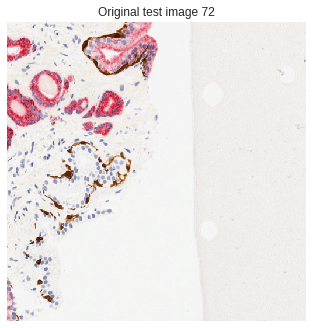

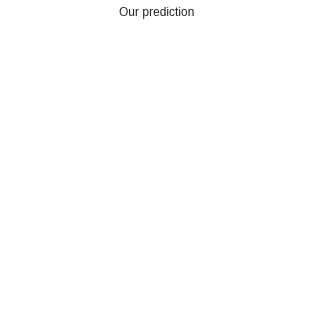

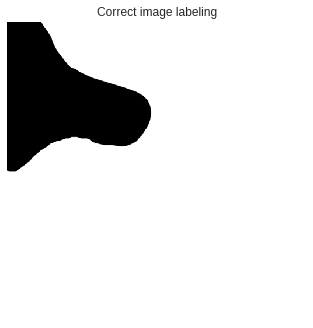

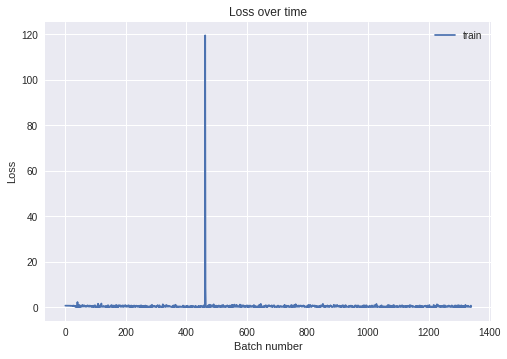

Epoch 3: loss 0.0857, acc. 0.984: 100%|██████████| 671/671 [20:56<00:00,  1.87s/it]


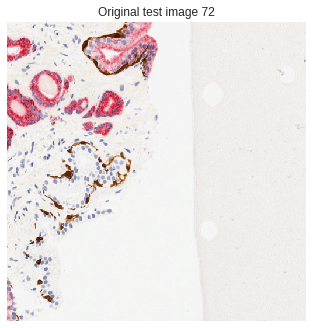

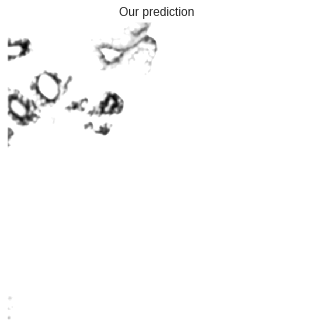

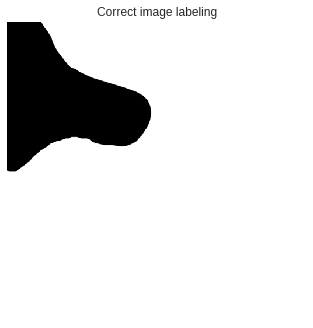

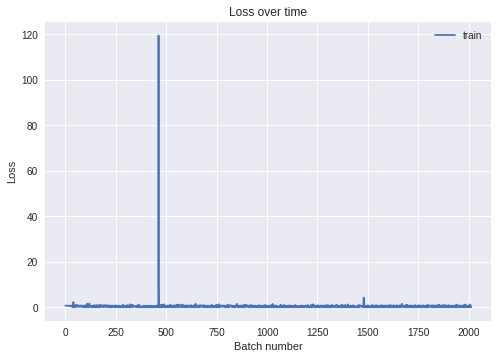

Epoch 4: loss 0.1680, acc. 0.952: 100%|██████████| 671/671 [20:57<00:00,  1.87s/it]


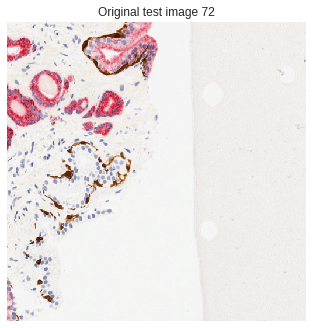

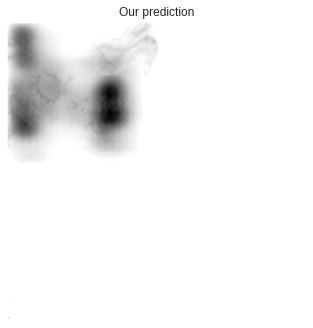

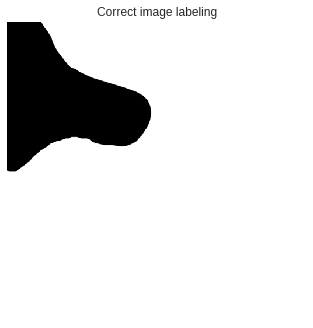

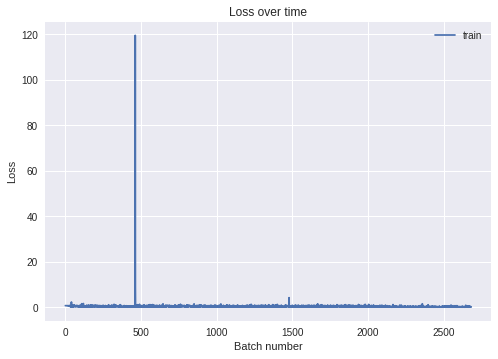

Epoch 5: loss 0.0268, acc. 0.997: 100%|██████████| 671/671 [20:44<00:00,  1.86s/it]


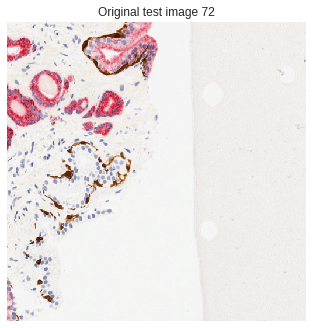

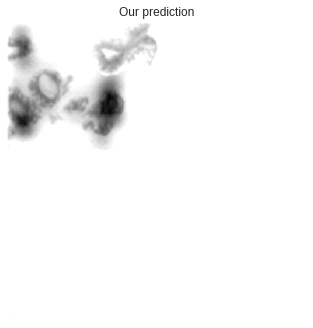

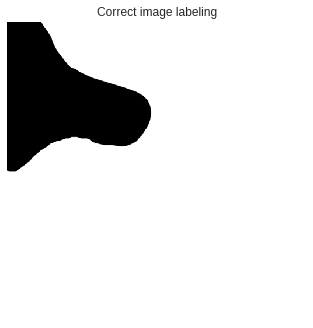

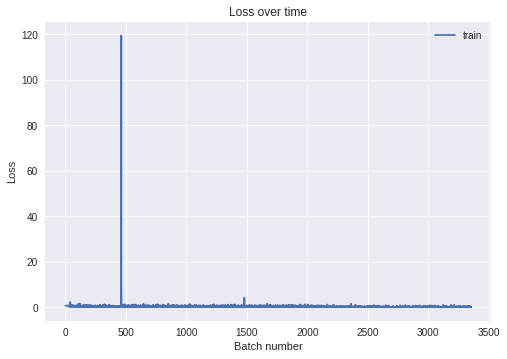

Epoch 6: loss 0.0502, acc. 0.970: 100%|██████████| 671/671 [20:37<00:00,  1.83s/it]


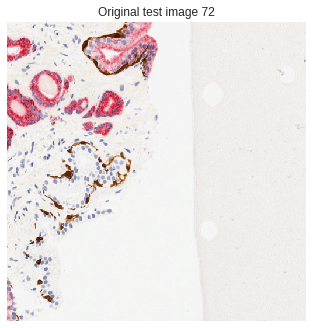

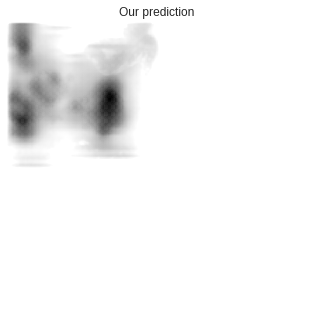

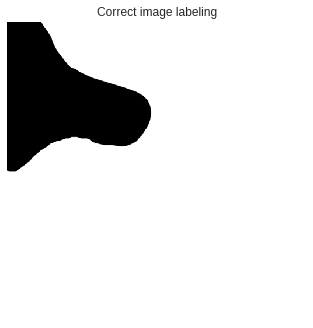

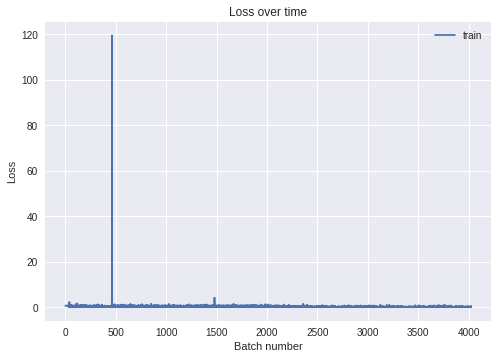

Epoch 7: loss 0.0951, acc. 0.947: 100%|██████████| 671/671 [20:38<00:00,  1.85s/it]


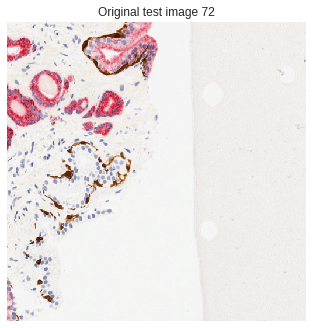

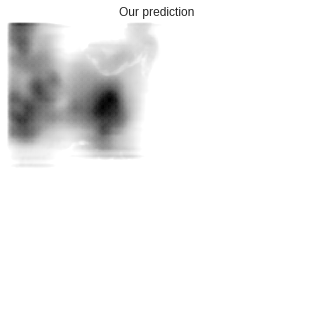

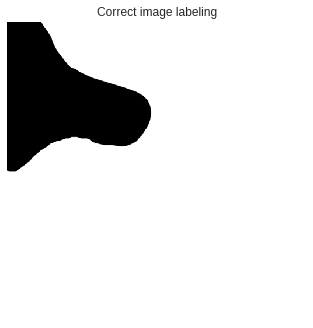

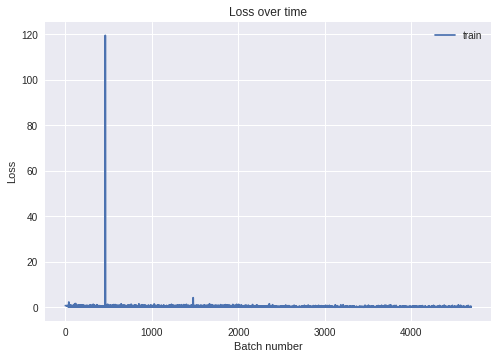

Epoch 8: loss 0.0585, acc. 0.987: 100%|██████████| 671/671 [20:52<00:00,  1.88s/it]


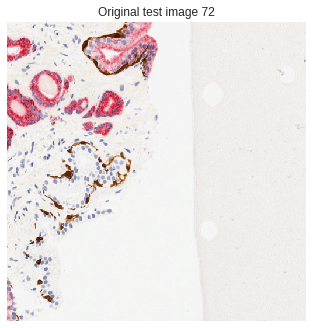

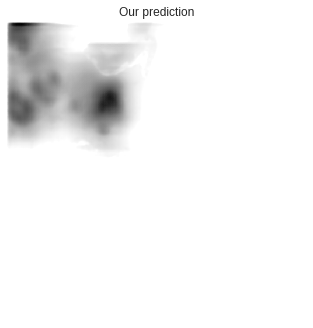

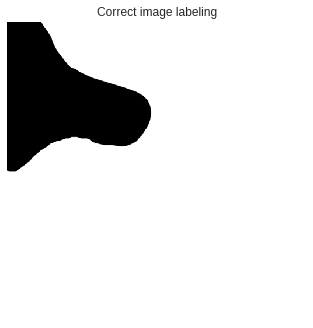

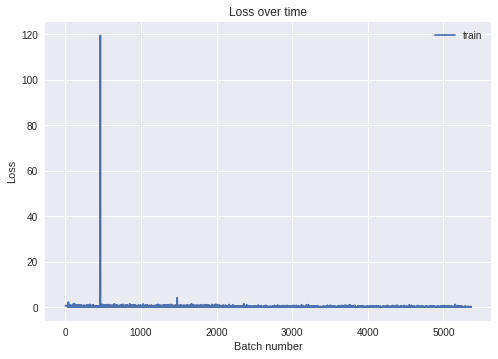

Epoch 9: loss 0.0276, acc. 1.000: 100%|██████████| 671/671 [20:57<00:00,  1.89s/it]


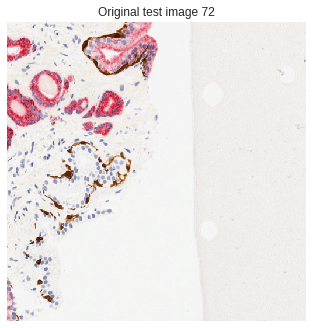

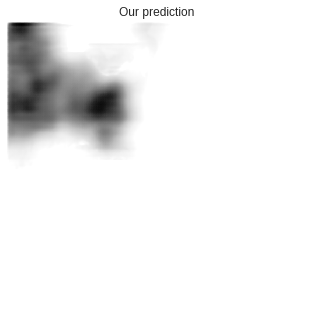

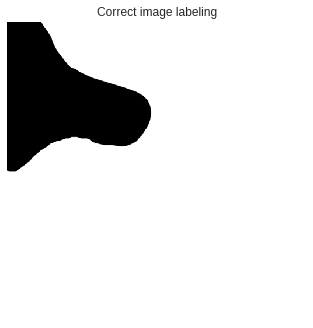

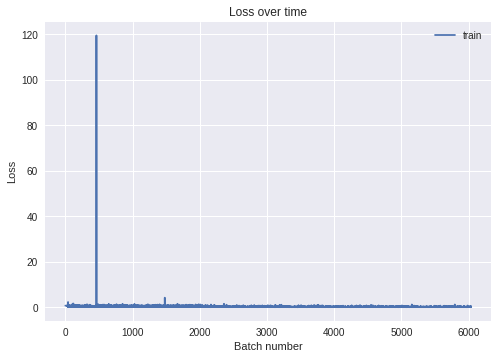

Epoch 10: loss 0.0241, acc. 1.000: 100%|██████████| 671/671 [21:06<00:00,  1.89s/it]


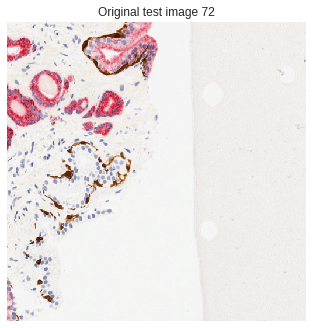

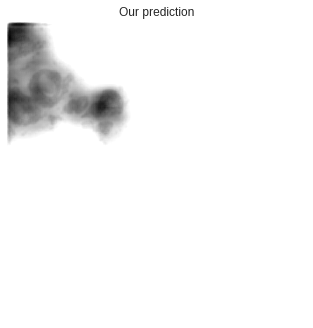

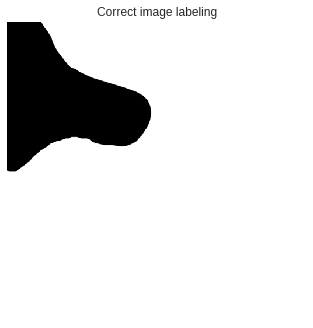

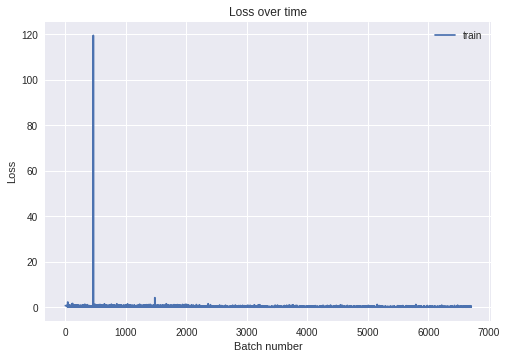

In [0]:
from google.colab import drive
drive.mount('/gdrive') 
import csv

def scope():
    
    try:
        
        # Start real small while training, to check if it works at all
        train_data = CancerDataset('C:/Users/Marissa', size=512)
        val_data = CancerDataset('C:/Users/Marissa', train=False)
        
        model = CancerDetector(train_data).cuda()
        objective = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=1e-4)
        
        BATCH_SIZE = 2
        train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, 
                                  shuffle=True, pin_memory=True)
        val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, 
                                shuffle=True, pin_memory=True)

        losses, validations, train_accuracies, val_accuracies = [], [], [], []
        
        gc.collect()
        print(torch.cuda.memory_allocated(0) / 1e9)
        
        num_epochs = 10
        
        for epoch in range(1,num_epochs+1):

            loop = tqdm(total=len(train_loader), position=0, leave=True)

            for batch, (x, y_truth) in enumerate(train_loader):
                
                x, y_truth = x.cuda(async=True), y_truth.cuda(async=True)
                optimizer.zero_grad()
                y_hat = model(x)
                
                # You need to feed the loss a shape (N, C, h, w) for the input 
                # and (N, h, w) for output, where N is batch size and C is the
                # number of classes. That does seem to be the case.
                #print(y_hat.size(), y_truth.size())
                loss = objective(y_hat, y_truth.long())
                
                a = torch.sum(y_truth.long() == torch.argmax(y_hat,dim=1))
                num_pixels = np.prod(np.array(list(y_truth.size())))
                a = float(a) / float(num_pixels)
                train_accuracies.append(a)

                loss.backward()
                #print(loss.item())
                losses.append(loss.item())

                s = "Epoch {}: loss {:.4f}, acc. {:.3f}".format(epoch, loss, a)
                loop.set_description(s)
                loop.update(1)

                optimizer.step()
                
            loop.close()
            
            torch.save(model, '/gdrive/My Drive/Colab Notebooks/my-model-epoch-'+str(epoch)+'.torch')
            with open("/gdrive/My Drive/Colab Notebooks/losses_saved.txt",'a') as csvfile:
                f = csv.writer(csvfile, delimiter=',')
                f.writerow([">>> LOSSES EPOCH " + str(epoch)])
                f.writerow(losses)
         
            display_results(losses, train_accuracies, val_data, model, epoch)

    except:
        
        torch.save(model, '/gdrive/My Drive/Colab Notebooks/FAILURE-my-model-epoch-'+str(epoch)+'.torch')
        with open("/gdrive/My Drive/Colab Notebooks/FAILURE_losses_saved.txt",'a') as csvfile:
            f = csv.writer(csvfile, delimiter=',')
            f.writerow([">>> LOSSES EPOCH " + str(epoch)])
            f.writerow(losses)
        display_results(losses, train_accuracies, val_data, model, epoch)
        __ITB__()
        
scope()